We'll start by loading the necessary libraries and the dataset from Huggingface.

In [2]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Download the Huggingface Emoji dataset
from datasets import load_dataset
dataset = load_dataset('valhalla/emoji-dataset')


/Users/tylersmith/anaconda3/envs/summarizer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We'll filter by "hair" as the theme for our emojis, just for fun. This way we can classify emojis by gender later on. 

In [29]:

def filter_images(dataset, theme):
    filtered_images = []
    for i, text in enumerate(dataset['train']['text']):
        if theme in text:
            filtered_images.append(dataset['train']['image'][i])
    return filtered_images


# Filter the images based on the theme
theme = 'hair'
filtered_images = filter_images(dataset, theme)

# Display the length of the filtered images
print(f"Number of images with the theme '{theme}': {len(filtered_images)}")

# Display the length of the original dataset
print(f"Number of images in the original dataset: {len(dataset['train']['image'])}")


Number of images with the theme 'hair': 61
Number of images in the original dataset: 2749


We'll create a train/validation/test split with a 60-20-20 divide. 

In [230]:
train_images, val_images = train_test_split(filtered_images, test_size=0.4, random_state=42) # 60% for training, 40% for validation and testing
val_images, test_images = train_test_split(val_images, test_size=0.5, random_state=42) # 20% for validation, 20% for testing

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 36
Number of validation images: 12
Number of test images: 13


We'll resize images to be 64x64 resolution. 

In [231]:
def resize_images(images, size):
    resized_images = []
    for image in images:
        img = image.resize(size)
        resized_images.append(img)
    return resized_images

# Resize the images
size = (64, 64)
train_images = resize_images(train_images, size)
val_images = resize_images(val_images, size)
test_images = resize_images(test_images, size)

Since our subset of the dataset is small, we'll expand to be closer to 600-200-200. 

In [232]:
train_images = train_images * (600 // len(train_images))
val_images = val_images * (200 // len(val_images))
test_images = test_images * (200 // len(test_images))


In [233]:
# Display the length of train_images, val_images, and test_images
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")


Number of training images: 576
Number of validation images: 192
Number of test images: 195


Now, we'll create an EmojiDataset class that will allow for transformations/data augmentation.

In [234]:
class EmojiDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image
    

We'll randomly apply horizontal flips and a 30 degree rotation to each dataset for augmentation. 

In [235]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

# Create the training, validation, and test datasets
train_dataset = EmojiDataset(train_images, transform=transform)
val_dataset = EmojiDataset(val_images, transform=transforms.ToTensor())
test_dataset = EmojiDataset(test_images, transform=transforms.ToTensor())


In [236]:
# Create the training, validation, and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Now we can start cooking with our Autoencoder. We'll take in our image and produce an output image of the same dimensions.

In [248]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=3, padding=1),  # b, 8, 22, 22
            nn.ReLU(True)
            )
        self.enconder2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),  # b, 8, 11, 11
            nn.Conv2d(8, 8, 3, stride=1, padding=1), # b, 8, 11, 11
            nn.ReLU(True) 
            )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # b, 16, 6, 6
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 16, 5, 5
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # b, 16, 5, 5
            nn.ReLU(True)
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2),  # b, 8, 11, 11
            nn.ReLU(True))
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),  # b, 8, 22, 22
            nn.ReLU(True))
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(8, 3, 3, stride=3, padding=1),  # b, 3, 64, 64
            nn.Tanh()
        )

    def forward(self, initial_x):
        # Autoencoder
        x1 = self.encoder1(initial_x)
        x2 = self.enconder2(x1)
        enc_x = self.encoder3(x2)
        out_x1 = 0 + self.decoder1(enc_x)
        if self.training:
            # Add random noise
            noise = torch.randn_like(x1)
            x1 = x1 + 0.05*noise
            out_x2 = x1 + self.decoder2(out_x1)
        else:
            out_x2 = x1 + self.decoder2(out_x1)
        x = self.decoder3(out_x2)
        
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/100 | Training loss: 13.7015
Epoch 1/100 | Validation loss: 14.5869


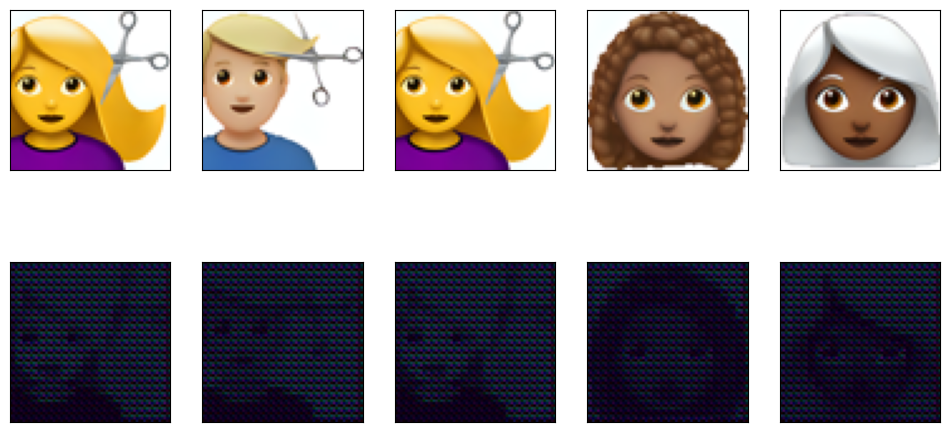

Epoch 2/100 | Training loss: 11.2782
Epoch 2/100 | Validation loss: 11.2985
Epoch 3/100 | Training loss: 8.1223
Epoch 3/100 | Validation loss: 7.8736
Epoch 4/100 | Training loss: 5.3846
Epoch 4/100 | Validation loss: 5.0377
Epoch 5/100 | Training loss: 3.4030
Epoch 5/100 | Validation loss: 3.0591
Epoch 6/100 | Training loss: 2.3172
Epoch 6/100 | Validation loss: 2.2213
Epoch 7/100 | Training loss: 1.8062
Epoch 7/100 | Validation loss: 1.8567
Epoch 8/100 | Training loss: 1.5198
Epoch 8/100 | Validation loss: 1.6301
Epoch 9/100 | Training loss: 1.3765
Epoch 9/100 | Validation loss: 1.4690
Epoch 10/100 | Training loss: 1.2890
Epoch 10/100 | Validation loss: 1.3174
Epoch 11/100 | Training loss: 1.2188
Epoch 11/100 | Validation loss: 1.1807
Epoch 12/100 | Training loss: 1.1530
Epoch 12/100 | Validation loss: 1.0601
Epoch 13/100 | Training loss: 1.0919
Epoch 13/100 | Validation loss: 0.9694
Epoch 14/100 | Training loss: 1.0404
Epoch 14/100 | Validation loss: 0.8953
Epoch 15/100 | Training lo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20/100 | Training loss: 0.8549
Epoch 20/100 | Validation loss: 0.6690


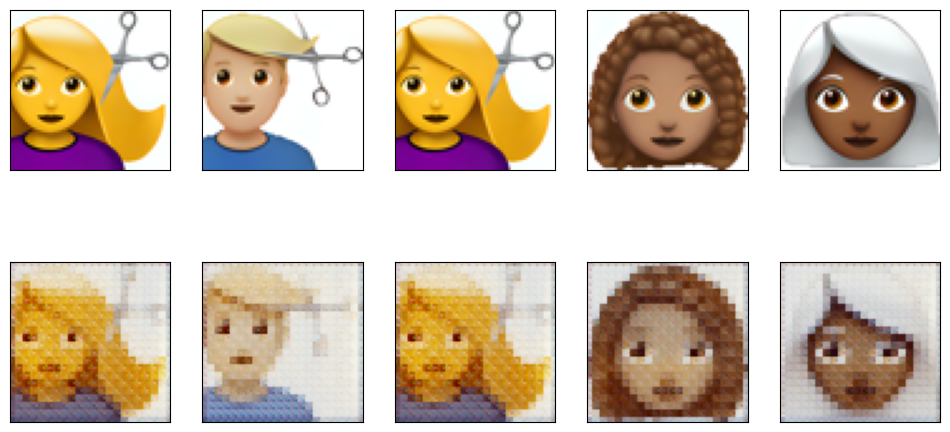

Epoch 21/100 | Training loss: 0.8351
Epoch 21/100 | Validation loss: 0.6461
Epoch 22/100 | Training loss: 0.8140
Epoch 22/100 | Validation loss: 0.6263
Epoch 23/100 | Training loss: 0.7989
Epoch 23/100 | Validation loss: 0.6048
Epoch 24/100 | Training loss: 0.7833
Epoch 24/100 | Validation loss: 0.5867
Epoch 25/100 | Training loss: 0.7717
Epoch 25/100 | Validation loss: 0.5783
Epoch 26/100 | Training loss: 0.7485
Epoch 26/100 | Validation loss: 0.5646
Epoch 27/100 | Training loss: 0.7401
Epoch 27/100 | Validation loss: 0.5617
Epoch 28/100 | Training loss: 0.7299
Epoch 28/100 | Validation loss: 0.5495
Epoch 29/100 | Training loss: 0.7158
Epoch 29/100 | Validation loss: 0.5365
Epoch 30/100 | Training loss: 0.7101
Epoch 30/100 | Validation loss: 0.5338
Epoch 31/100 | Training loss: 0.6980
Epoch 31/100 | Validation loss: 0.5316
Epoch 32/100 | Training loss: 0.6908
Epoch 32/100 | Validation loss: 0.5147
Epoch 33/100 | Training loss: 0.6816
Epoch 33/100 | Validation loss: 0.5140
Epoch 34/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40/100 | Training loss: 0.6346
Epoch 40/100 | Validation loss: 0.4706


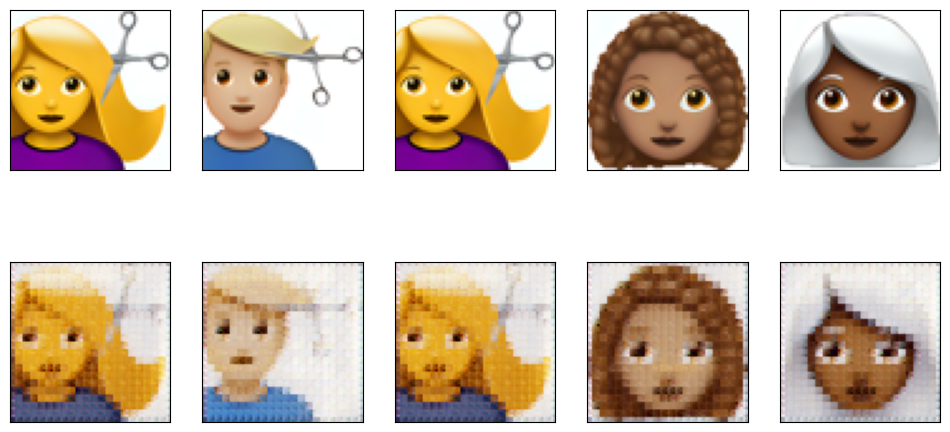

Epoch 41/100 | Training loss: 0.6250
Epoch 41/100 | Validation loss: 0.4682
Epoch 42/100 | Training loss: 0.6187
Epoch 42/100 | Validation loss: 0.4590
Epoch 43/100 | Training loss: 0.6184
Epoch 43/100 | Validation loss: 0.4563
Epoch 44/100 | Training loss: 0.6135
Epoch 44/100 | Validation loss: 0.4652
Epoch 45/100 | Training loss: 0.6092
Epoch 45/100 | Validation loss: 0.4440
Epoch 46/100 | Training loss: 0.6053
Epoch 46/100 | Validation loss: 0.4485
Epoch 47/100 | Training loss: 0.5995
Epoch 47/100 | Validation loss: 0.4440
Epoch 48/100 | Training loss: 0.5968
Epoch 48/100 | Validation loss: 0.4416
Epoch 49/100 | Training loss: 0.5919
Epoch 49/100 | Validation loss: 0.4432
Epoch 50/100 | Training loss: 0.5884
Epoch 50/100 | Validation loss: 0.4354
Epoch 51/100 | Training loss: 0.5861
Epoch 51/100 | Validation loss: 0.4320
Epoch 52/100 | Training loss: 0.5831
Epoch 52/100 | Validation loss: 0.4320
Epoch 53/100 | Training loss: 0.5803
Epoch 53/100 | Validation loss: 0.4321
Epoch 54/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60/100 | Training loss: 0.5480
Epoch 60/100 | Validation loss: 0.4106


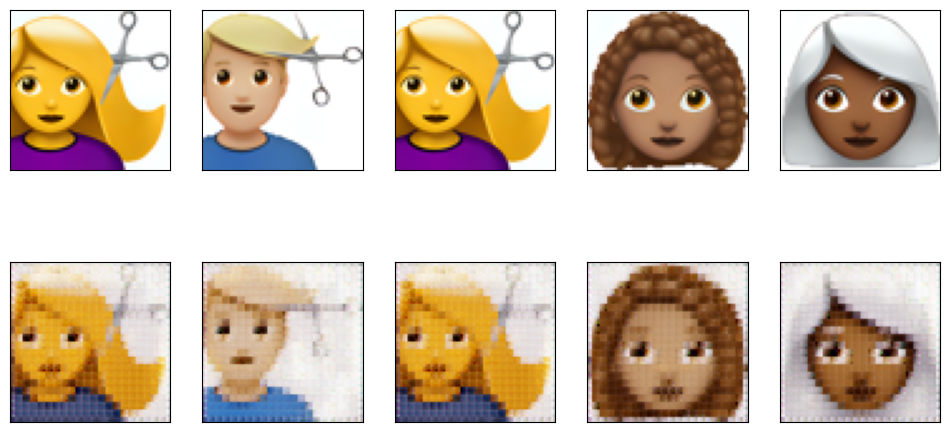

Epoch 61/100 | Training loss: 0.5443
Epoch 61/100 | Validation loss: 0.4105
Epoch 62/100 | Training loss: 0.5374
Epoch 62/100 | Validation loss: 0.4008
Epoch 63/100 | Training loss: 0.5302
Epoch 63/100 | Validation loss: 0.3905
Epoch 64/100 | Training loss: 0.5261
Epoch 64/100 | Validation loss: 0.3855
Epoch 65/100 | Training loss: 0.5199
Epoch 65/100 | Validation loss: 0.3846
Epoch 66/100 | Training loss: 0.5139
Epoch 66/100 | Validation loss: 0.3787
Epoch 67/100 | Training loss: 0.4986
Epoch 67/100 | Validation loss: 0.3721
Epoch 68/100 | Training loss: 0.4793
Epoch 68/100 | Validation loss: 0.3553
Epoch 69/100 | Training loss: 0.4597
Epoch 69/100 | Validation loss: 0.3406
Epoch 70/100 | Training loss: 0.4421
Epoch 70/100 | Validation loss: 0.3324
Epoch 71/100 | Training loss: 0.4318
Epoch 71/100 | Validation loss: 0.3269
Epoch 72/100 | Training loss: 0.4208
Epoch 72/100 | Validation loss: 0.3244
Epoch 73/100 | Training loss: 0.4157
Epoch 73/100 | Validation loss: 0.3143
Epoch 74/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80/100 | Training loss: 0.3845
Epoch 80/100 | Validation loss: 0.2919


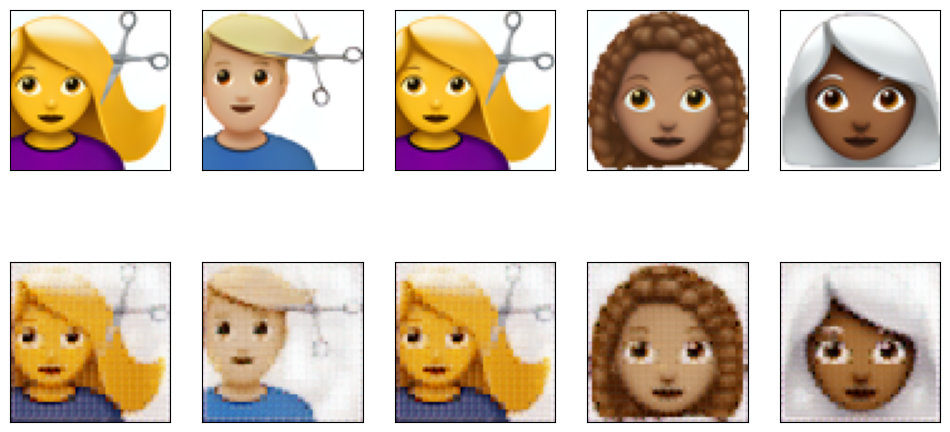

Epoch 81/100 | Training loss: 0.3803
Epoch 81/100 | Validation loss: 0.2894
Epoch 82/100 | Training loss: 0.3763
Epoch 82/100 | Validation loss: 0.2840
Epoch 83/100 | Training loss: 0.3737
Epoch 83/100 | Validation loss: 0.2860
Epoch 84/100 | Training loss: 0.3697
Epoch 84/100 | Validation loss: 0.2777
Epoch 85/100 | Training loss: 0.3663
Epoch 85/100 | Validation loss: 0.2750
Epoch 86/100 | Training loss: 0.3646
Epoch 86/100 | Validation loss: 0.2781
Epoch 87/100 | Training loss: 0.3616
Epoch 87/100 | Validation loss: 0.2705
Epoch 88/100 | Training loss: 0.3575
Epoch 88/100 | Validation loss: 0.2680
Epoch 89/100 | Training loss: 0.3549
Epoch 89/100 | Validation loss: 0.2709
Epoch 90/100 | Training loss: 0.3525
Epoch 90/100 | Validation loss: 0.2673
Epoch 91/100 | Training loss: 0.3503
Epoch 91/100 | Validation loss: 0.2683
Epoch 92/100 | Training loss: 0.3461
Epoch 92/100 | Validation loss: 0.2635
Epoch 93/100 | Training loss: 0.3415
Epoch 93/100 | Validation loss: 0.2580
Epoch 94/100

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100/100 | Training loss: 0.3257
Epoch 100/100 | Validation loss: 0.2455


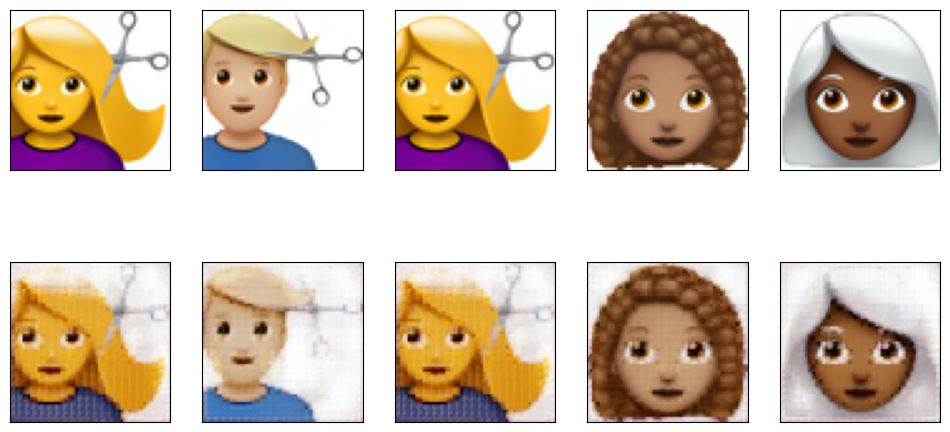

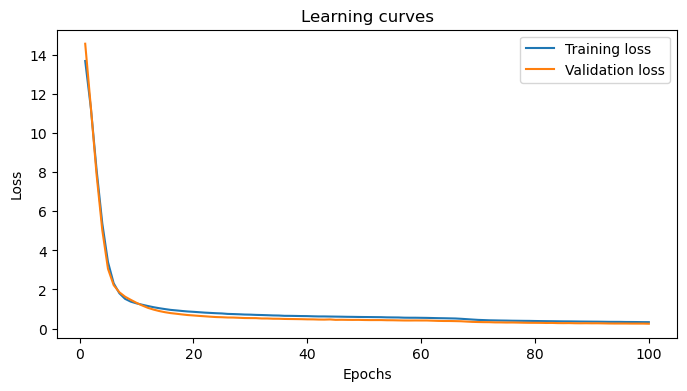

Test loss: 0.2495


In [249]:
import matplotlib.pyplot as plt

torch.manual_seed(42)

# Create the autoencoder model
model = Autoencoder()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 100

train_losses = []
val_losses = []

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0.0
    for data in train_dataloader:
        images = data
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_dataloader)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{n_epochs} | Training loss: {train_loss:.4f}")

    # Validate the model
    val_loss = 0.0
    model.eval()
    for data in val_dataloader:
        images = data
        outputs = model(images)
        loss = criterion(outputs, images)
        val_loss += loss.item() * images.size(0)
    val_loss = val_loss / len(val_dataloader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{n_epochs} | Validation loss: {val_loss:.4f}")

    # Display the test images and the reconstructed images from the autoencoder. This will allow us to see how well we're performing. 
    if epoch == 1 or epoch % 20 == 0:
        test_images = next(iter(test_dataloader))
        reconstructed_images = model(test_images)
        test_images = test_images.numpy()
        reconstructed_images = reconstructed_images.detach().numpy()
        fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
        for images, row in zip([test_images, reconstructed_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(np.squeeze(img).transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        plt.show()

    # Display learning curves
    if epoch == n_epochs:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(1, epoch+1), train_losses, label='Training loss')
        ax.plot(range(1, epoch+1), val_losses, label='Validation loss')
        ax.set_title('Learning curves')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()


# Save the model
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'autoencoder.pth')
torch.save(model.state_dict(), model_path)

# Load the model
model = Autoencoder()
model.load_state_dict(torch.load(model_path))

# Evaluate the model
test_loss = 0.0
model.eval()
for data in test_dataloader:
    images = data
    outputs = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item() * images.size(0)

# Calculate the average test loss
test_loss = test_loss / len(test_dataloader)
print(f"Test loss: {test_loss:.4f}")


# Problem 2

In [3]:
def filter_and_label_images(dataset, theme):
    filtered_images = []
    labels = []
    for i, text in enumerate(dataset['train']['text']):
        if theme in text:
            if 'woman' in text:
                labels.append(1)
                filtered_images.append(dataset['train']['image'][i])
            elif 'man' in text:
                labels.append(0)
                filtered_images.append(dataset['train']['image'][i])
            # elif 'person' in text:
            #     labels.append(2)
            #     filtered_images.append(dataset['train']['image'][i])
            # else:
            #     labels.append(3)
            #     filtered_images.append(dataset['train']['image'][i])
    return filtered_images, labels

# Filter the images and assign labels
theme = 'hair'
filtered_images, labels = filter_and_label_images(dataset, theme)

# Display the length of the filtered images and labels
print(f"Number of images with the theme '{theme}': {len(filtered_images)}")
print(f"Number of labels: {len(labels)}")


Number of images with the theme 'hair': 48
Number of labels: 48


In [4]:
def resize_images(images, size):
    resized_images = []
    for image in images:
        img = image.resize(size)
        resized_images.append(img)
    return resized_images

# Resize the images
size = (64, 64)
resized_images = resize_images(filtered_images, size)

In [5]:
# Let's split the images and corresponding labels into training, validation, and test sets using a 60-20-20 split.
train_images, val_test_images, train_labels, val_test_labels = train_test_split(resized_images, labels, test_size=0.4, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(val_test_images, val_test_labels, test_size=0.5, random_state=42)

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 28
Number of validation images: 10
Number of test images: 10


In [7]:
# Expand the dataset by duplicating the images and labels to be 600, 200, and 200 for the training, validation, and test sets, respectively.
train_images = train_images * (600 // len(train_images))
val_images = val_images * (200 // len(val_images))
test_images = test_images * (200 // len(test_images))
train_labels = train_labels * (600 // len(train_labels))
val_labels = val_labels * (200 // len(val_labels))
test_labels = test_labels * (200 // len(test_labels))

# Display the number of images in each set
print(f"Number of training images: {len(train_images)}")
print(f"Number of validation images: {len(val_images)}")
print(f"Number of test images: {len(test_images)}")

Number of training images: 588
Number of validation images: 200
Number of test images: 200


In [8]:
# Create the EmojiDataset2 class to load the images and labels
class EmojiDataset2(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [9]:
# Create the training, validation, and test datasets
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor()
])

train_dataset2 = EmojiDataset2(train_images, train_labels, transform=transform)
val_dataset2 = EmojiDataset2(val_images, val_labels, transform=transforms.ToTensor())
test_dataset2 = EmojiDataset2(test_images, test_labels, transform=transforms.ToTensor())

# Create the training, validation, and test dataloaders
train_dataloader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True)
val_dataloader2 = DataLoader(val_dataset2, batch_size=32, shuffle=False)
test_dataloader2 = DataLoader(test_dataset2, batch_size=32, shuffle=False)

In [26]:
import torch.nn.functional as F

class AutoencoderWithClassifier(nn.Module):
    def __init__(self):
        super(AutoencoderWithClassifier, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, stride=3, padding=1),  # b, 8, 22, 22
            nn.ReLU(True)
            )
        self.enconder2 = nn.Sequential(
            nn.MaxPool2d(2, stride=2),  # b, 8, 11, 11
            nn.Conv2d(8, 8, 3, stride=1, padding=1), # b, 8, 11, 11
            nn.ReLU(True) 
            )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),  # b, 16, 6, 6
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 16, 5, 5
            nn.Conv2d(16, 16, 3, stride=1, padding=1),  # b, 16, 5, 5
            nn.ReLU(True)
        )
        
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2),  # b, 8, 11, 11
            nn.ReLU(True))
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1, output_padding=1),  # b, 8, 22, 22
            nn.ReLU(True))
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(8, 3, 3, stride=3, padding=1),  # b, 3, 64, 64
            nn.Tanh()
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.85),
            nn.Linear(16 * 5 * 5, 32),
            nn.LeakyReLU(True),
            nn.Dropout(0.9),
            nn.Linear(32, 16),
            nn.LeakyReLU(True),
            nn.Dropout(0.85),
            nn.Linear(16, 2)
        )

    def forward(self, initial_x):
        # Autoencoder
        x1 = self.encoder1(initial_x)
        x2 = self.enconder2(x1)
        enc_x = self.encoder3(x2)
        out_x1 = self.decoder1(enc_x)
        if self.training:
            # Add random noise
            noise = torch.randn_like(x1)
            x1 = x1 + 0.05*noise
            out_x2 = x1 + self.decoder2(out_x1)
        out_x2 = x1 + self.decoder2(out_x1)
        x = self.decoder3(out_x2)
        
        # Classifier
        aux = self.classifier(enc_x)
        return x, aux

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1/100 | Training loss: 12.4221 | MSE loss: 12.3994 | Classifier loss: 22.7276
Epoch 1/100 | Validation loss: 13.8135 | MSE loss: 13.7937 | Classifier loss: 19.8187


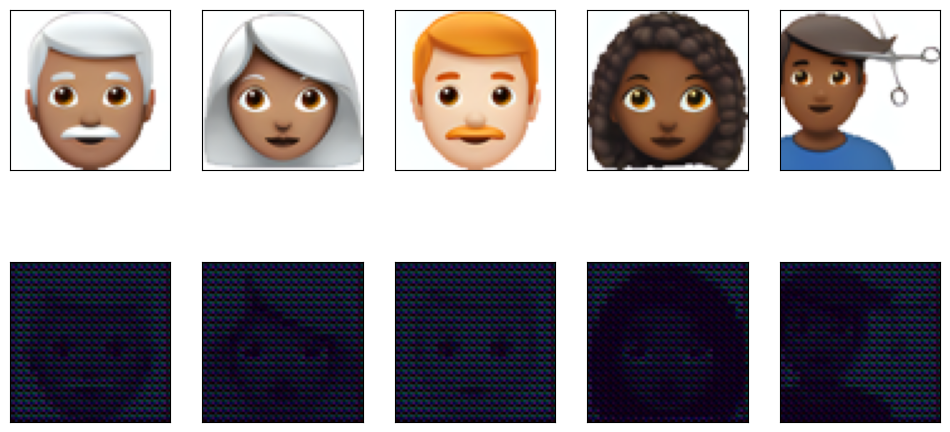

Epoch 2/100 | Training loss: 10.1312 | MSE loss: 10.0968 | Classifier loss: 34.3332
Epoch 2/100 | Validation loss: 10.1952 | MSE loss: 10.1747 | Classifier loss: 20.5070
Epoch 3/100 | Training loss: 7.1956 | MSE loss: 7.1429 | Classifier loss: 52.6615
Epoch 3/100 | Validation loss: 6.4454 | MSE loss: 6.4258 | Classifier loss: 19.6563
Epoch 4/100 | Training loss: 4.5296 | MSE loss: 4.4775 | Classifier loss: 52.1197
Epoch 4/100 | Validation loss: 3.7706 | MSE loss: 3.7509 | Classifier loss: 19.6510
Epoch 5/100 | Training loss: 2.8022 | MSE loss: 2.7611 | Classifier loss: 41.0629
Epoch 5/100 | Validation loss: 2.1385 | MSE loss: 2.1189 | Classifier loss: 19.6567
Epoch 6/100 | Training loss: 1.8897 | MSE loss: 1.8614 | Classifier loss: 28.2826
Epoch 6/100 | Validation loss: 1.5073 | MSE loss: 1.4877 | Classifier loss: 19.6093
Epoch 7/100 | Training loss: 1.5269 | MSE loss: 1.5035 | Classifier loss: 23.4398
Epoch 7/100 | Validation loss: 1.2497 | MSE loss: 1.2301 | Classifier loss: 19.6552


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20/100 | Training loss: 0.7975 | MSE loss: 0.7746 | Classifier loss: 22.8788
Epoch 20/100 | Validation loss: 0.5544 | MSE loss: 0.5346 | Classifier loss: 19.8460


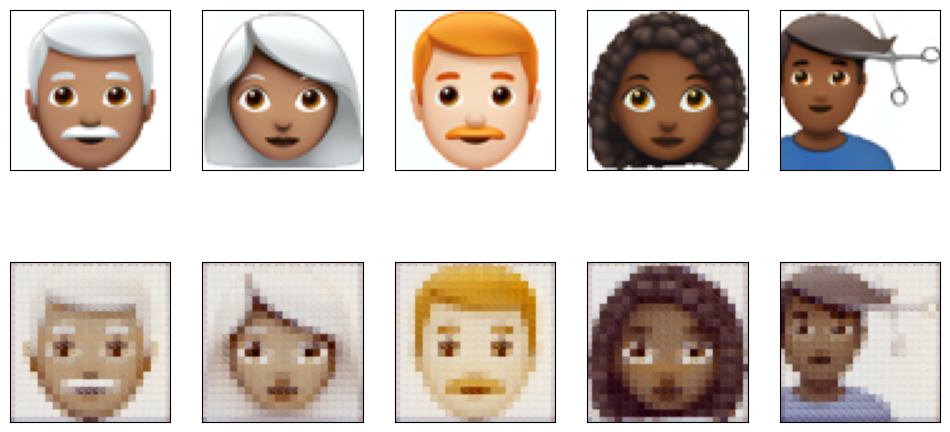

Epoch 21/100 | Training loss: 0.7836 | MSE loss: 0.7611 | Classifier loss: 22.5353
Epoch 21/100 | Validation loss: 0.5425 | MSE loss: 0.5227 | Classifier loss: 19.8577
Epoch 22/100 | Training loss: 0.7670 | MSE loss: 0.7452 | Classifier loss: 21.8836
Epoch 22/100 | Validation loss: 0.5324 | MSE loss: 0.5126 | Classifier loss: 19.8569
Epoch 23/100 | Training loss: 0.7551 | MSE loss: 0.7331 | Classifier loss: 22.0143
Epoch 23/100 | Validation loss: 0.5213 | MSE loss: 0.5014 | Classifier loss: 19.8424
Epoch 24/100 | Training loss: 0.7409 | MSE loss: 0.7191 | Classifier loss: 21.7638
Epoch 24/100 | Validation loss: 0.5134 | MSE loss: 0.4936 | Classifier loss: 19.8387
Epoch 25/100 | Training loss: 0.7304 | MSE loss: 0.7087 | Classifier loss: 21.7308
Epoch 25/100 | Validation loss: 0.5065 | MSE loss: 0.4866 | Classifier loss: 19.8380
Epoch 26/100 | Training loss: 0.7164 | MSE loss: 0.6945 | Classifier loss: 21.8636
Epoch 26/100 | Validation loss: 0.4940 | MSE loss: 0.4742 | Classifier loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40/100 | Training loss: 0.6044 | MSE loss: 0.5828 | Classifier loss: 21.5800
Epoch 40/100 | Validation loss: 0.4279 | MSE loss: 0.4080 | Classifier loss: 19.8503


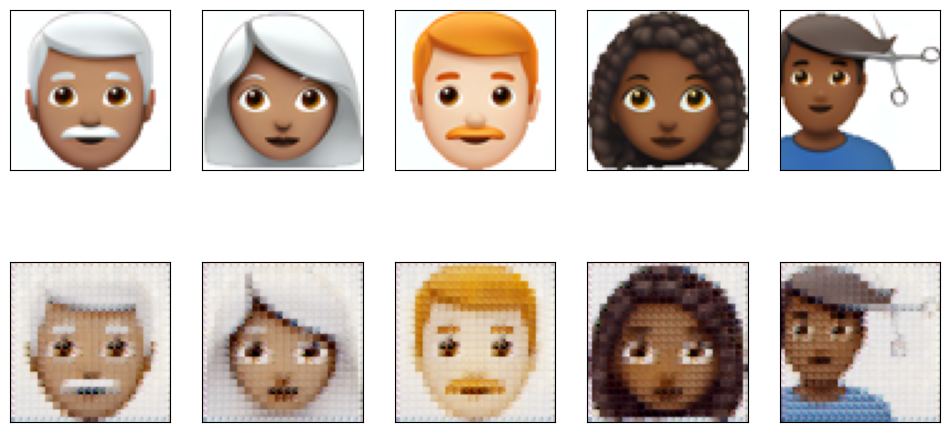

Epoch 41/100 | Training loss: 0.5997 | MSE loss: 0.5781 | Classifier loss: 21.6041
Epoch 41/100 | Validation loss: 0.4259 | MSE loss: 0.4060 | Classifier loss: 19.8506
Epoch 42/100 | Training loss: 0.5950 | MSE loss: 0.5735 | Classifier loss: 21.4706
Epoch 42/100 | Validation loss: 0.4221 | MSE loss: 0.4023 | Classifier loss: 19.8136
Epoch 43/100 | Training loss: 0.5894 | MSE loss: 0.5677 | Classifier loss: 21.7435
Epoch 43/100 | Validation loss: 0.4251 | MSE loss: 0.4053 | Classifier loss: 19.8732
Epoch 44/100 | Training loss: 0.5797 | MSE loss: 0.5583 | Classifier loss: 21.4164
Epoch 44/100 | Validation loss: 0.4144 | MSE loss: 0.3945 | Classifier loss: 19.9417
Epoch 45/100 | Training loss: 0.5751 | MSE loss: 0.5532 | Classifier loss: 21.8681
Epoch 45/100 | Validation loss: 0.4095 | MSE loss: 0.3896 | Classifier loss: 19.9367
Epoch 46/100 | Training loss: 0.5646 | MSE loss: 0.5431 | Classifier loss: 21.4970
Epoch 46/100 | Validation loss: 0.4091 | MSE loss: 0.3891 | Classifier loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60/100 | Training loss: 0.4246 | MSE loss: 0.4030 | Classifier loss: 21.5172
Epoch 60/100 | Validation loss: 0.3244 | MSE loss: 0.3047 | Classifier loss: 19.6885


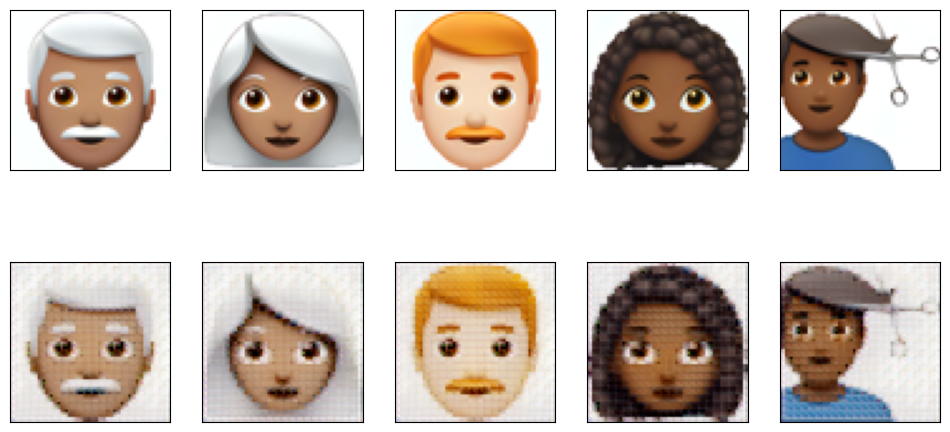

Epoch 61/100 | Training loss: 0.4213 | MSE loss: 0.3999 | Classifier loss: 21.4680
Epoch 61/100 | Validation loss: 0.3224 | MSE loss: 0.3027 | Classifier loss: 19.6786
Epoch 62/100 | Training loss: 0.4176 | MSE loss: 0.3965 | Classifier loss: 21.0586
Epoch 62/100 | Validation loss: 0.3188 | MSE loss: 0.2992 | Classifier loss: 19.5521
Epoch 63/100 | Training loss: 0.4148 | MSE loss: 0.3932 | Classifier loss: 21.6661
Epoch 63/100 | Validation loss: 0.3188 | MSE loss: 0.2990 | Classifier loss: 19.7301
Epoch 64/100 | Training loss: 0.4120 | MSE loss: 0.3910 | Classifier loss: 21.0655
Epoch 64/100 | Validation loss: 0.3180 | MSE loss: 0.2987 | Classifier loss: 19.2662
Epoch 65/100 | Training loss: 0.4073 | MSE loss: 0.3865 | Classifier loss: 20.8916
Epoch 65/100 | Validation loss: 0.3117 | MSE loss: 0.2926 | Classifier loss: 19.1144
Epoch 66/100 | Training loss: 0.4061 | MSE loss: 0.3848 | Classifier loss: 21.2596
Epoch 66/100 | Validation loss: 0.3112 | MSE loss: 0.2921 | Classifier loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80/100 | Training loss: 0.3619 | MSE loss: 0.3424 | Classifier loss: 19.4888
Epoch 80/100 | Validation loss: 0.2724 | MSE loss: 0.2571 | Classifier loss: 15.2601


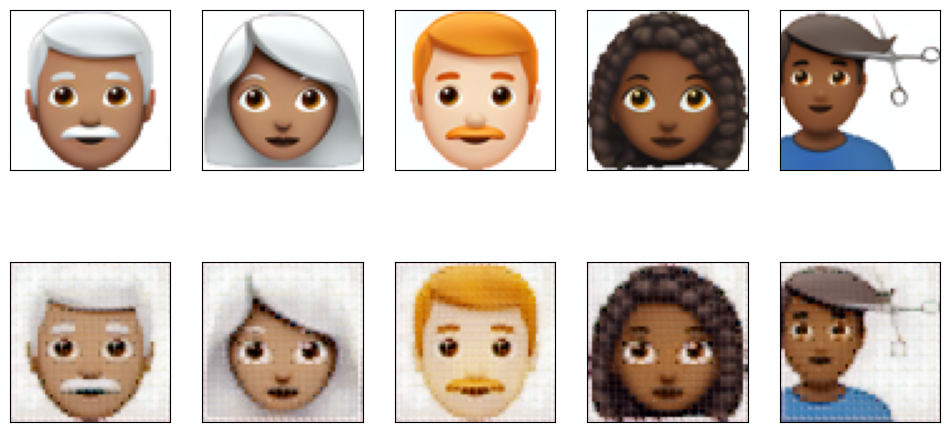

Epoch 81/100 | Training loss: 0.3573 | MSE loss: 0.3372 | Classifier loss: 20.0914
Epoch 81/100 | Validation loss: 0.2709 | MSE loss: 0.2556 | Classifier loss: 15.2865
Epoch 82/100 | Training loss: 0.3553 | MSE loss: 0.3356 | Classifier loss: 19.7332
Epoch 82/100 | Validation loss: 0.2681 | MSE loss: 0.2523 | Classifier loss: 15.7530
Epoch 83/100 | Training loss: 0.3504 | MSE loss: 0.3317 | Classifier loss: 18.7618
Epoch 83/100 | Validation loss: 0.2685 | MSE loss: 0.2538 | Classifier loss: 14.6773
Epoch 84/100 | Training loss: 0.3512 | MSE loss: 0.3315 | Classifier loss: 19.7088
Epoch 84/100 | Validation loss: 0.2646 | MSE loss: 0.2498 | Classifier loss: 14.8499
Epoch 85/100 | Training loss: 0.3430 | MSE loss: 0.3245 | Classifier loss: 18.5406
Epoch 85/100 | Validation loss: 0.2628 | MSE loss: 0.2493 | Classifier loss: 13.5400
Epoch 86/100 | Training loss: 0.3403 | MSE loss: 0.3224 | Classifier loss: 17.9973
Epoch 86/100 | Validation loss: 0.2566 | MSE loss: 0.2446 | Classifier loss: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100/100 | Training loss: 0.3005 | MSE loss: 0.2876 | Classifier loss: 12.8953
Epoch 100/100 | Validation loss: 0.2247 | MSE loss: 0.2216 | Classifier loss: 3.0910


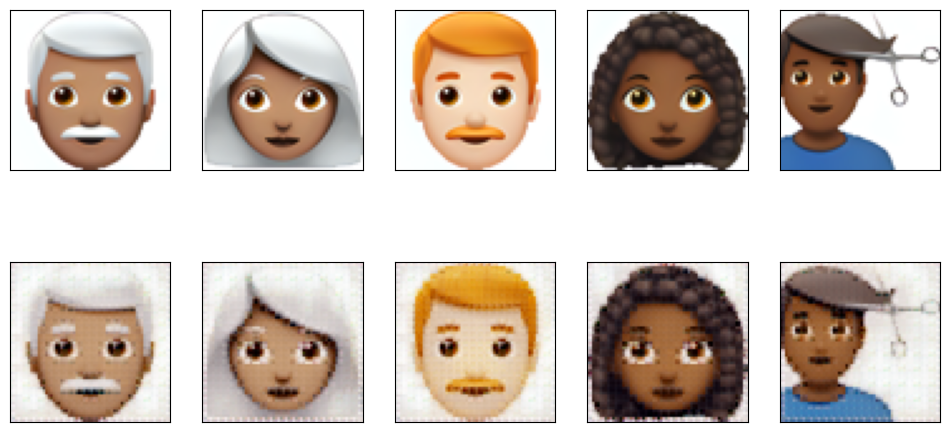

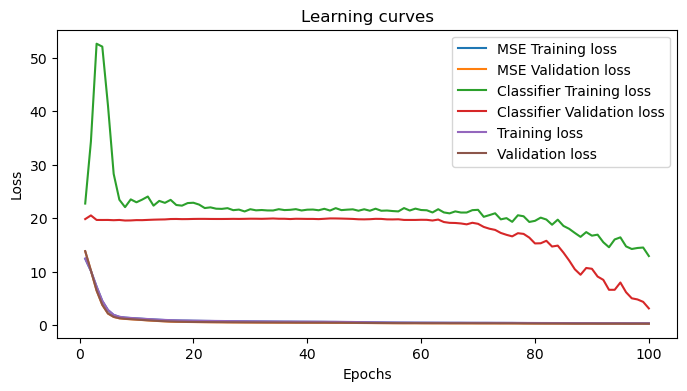

Test loss: 0.1780


In [27]:
import matplotlib.pyplot as plt
# Train the model
torch.manual_seed(42)

# Create the autoencoder model
model = AutoencoderWithClassifier()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
classifier_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001)

# Train the model
n_epochs = 100

train_losses = []
mse_losses = []
classifier_losses = []
val_mse_losses = []
val_classifier_losses = []
val_losses = []

# Train the model with the auxiliary classifier included in the loss function
# L = L_autoencoder + lambda*L_classifier
# lambda is the auxiliary_loss_weight
auxiliary_loss_weight = .001
for epoch in range(1, n_epochs+1):
    mse_loss = 0.0
    classifier_loss = 0.0
    train_loss = 0.0
    model.train()
    for data in train_dataloader2:
        images, labels = data
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)
        mse = criterion(outputs, images)
        classifier = classifier_criterion(aux_outputs, labels)
        loss = mse + auxiliary_loss_weight * classifier
        loss.backward()
        optimizer.step()
        mse_loss += mse.item() * images.size(0)
        classifier_loss += classifier.item() * images.size(0)
        train_loss += loss.item() * images.size(0)
    mse_loss = mse_loss / len(train_dataloader2)
    classifier_loss = classifier_loss / len(train_dataloader2)
    train_loss = train_loss / len(train_dataloader2)
    mse_losses.append(mse_loss)
    classifier_losses.append(classifier_loss)
    train_losses.append(train_loss)
    print(f"Epoch {epoch}/{n_epochs} | Training loss: {train_loss:.4f} | MSE loss: {mse_loss:.4f} | Classifier loss: {classifier_loss:.4f}")

    # Validate the model
    val_mse = 0.0
    val_classifier = 0.0
    val_loss = 0.0
    model.eval()
    # with torch.no_grad():
    for data in val_dataloader2:
        images, labels = data
        outputs, aux_outputs = model(images)
        val_mse_loss = criterion(outputs, images)
        val_classifier_loss = classifier_criterion(aux_outputs, labels)
        loss = val_mse_loss + auxiliary_loss_weight * val_classifier_loss
        val_mse += val_mse_loss.item() * images.size(0)
        val_classifier += val_classifier_loss.item() * images.size(0)
        val_loss += loss.item() * images.size(0)
    val_mse = val_mse / len(val_dataloader2)
    val_classifier = val_classifier / len(val_dataloader2)
    val_loss = val_loss / len(val_dataloader2)
    val_mse_losses.append(val_mse)
    val_classifier_losses.append(val_classifier)
    val_losses.append(val_loss)
    print(f"Epoch {epoch}/{n_epochs} | Validation loss: {val_loss:.4f} | MSE loss: {val_mse:.4f} | Classifier loss: {val_classifier:.4f}")

    # Display the test images and the reconstructed images from the autoencoder. This will allow us to see how well we're performing. 
    if epoch == 1 or epoch % 20 == 0:
        test_images, _ = next(iter(test_dataloader2))
        reconstructed_images, _ = model(test_images)
        test_images = test_images.numpy()
        reconstructed_images = reconstructed_images.detach().numpy()
        fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, figsize=(12, 6))
        for images, row in zip([test_images, reconstructed_images], axes):
            for img, ax in zip(images, row):
                ax.imshow(np.squeeze(img).transpose(1, 2, 0))
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
        plt.show()

    # Display learning curves
    if epoch == n_epochs:
        fig, ax = plt.subplots(figsize=(8, 4))
        ax.plot(range(1, epoch+1), mse_losses, label='MSE Training loss')
        ax.plot(range(1, epoch+1), val_mse_losses, label='MSE Validation loss')
        ax.plot(range(1, epoch+1), classifier_losses, label='Classifier Training loss')
        ax.plot(range(1, epoch+1), val_classifier_losses, label='Classifier Validation loss')
        ax.plot(range(1, epoch+1), train_losses, label='Training loss')
        ax.plot(range(1, epoch+1), val_losses, label='Validation loss')
        ax.set_title('Learning curves')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()


# Save the model
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, 'autoencoderwithclassifier.pth')
torch.save(model.state_dict(), model_path)

# Load the model
model = AutoencoderWithClassifier()
model.load_state_dict(torch.load(model_path))

# Evaluate the model
test_loss = 0.0
model.eval()
for data in test_dataloader2:
    images, labels = data
    outputs, _ = model(images)
    loss = criterion(outputs, images)
    test_loss += loss.item() * images.size(0)

# Calculate the average test loss
test_loss = test_loss / len(test_dataloader2)
print(f"Test loss: {test_loss:.4f}")

## Problem 2 Discussion
We see that adding the auxiliary task improves our autoencoder's performance, .1780 with the auxiliary task vs. .2495 without on the same Autoencoder structure and hyperparameters. We can squeeze just a little bit more out of this model by having it create a latent encoding that more closely resembles the important features of the original image (ie such that it can be properly classified as man or woman). However, because the classification task is significantly easier than the autoencoding task, this was actually very difficult to tune (Hence we set some ridiculous Dropouts to keep the classifier from converging too early). Improperly setting the lambda hyperparameter can lead to the model overemphasizing features important to the classification task such that there is underflow to the autoencoding task and it performs worse. Having a more robust dataset and classification task would help with this as it would force the model to create a broad latent encoding that is more representative of the original image while emphasizing important features for classification.

# Problem 3

In [30]:
# Get glasses images

theme = 'nerd'
nerd = filter_images(dataset, theme)

bald= filter_images(dataset, 'man bald')

# Resize the images
size = (64, 64)
nerd = resize_images(nerd, size)
bald = resize_images(bald, size)
nerd = nerd[0]
bald = bald[0]

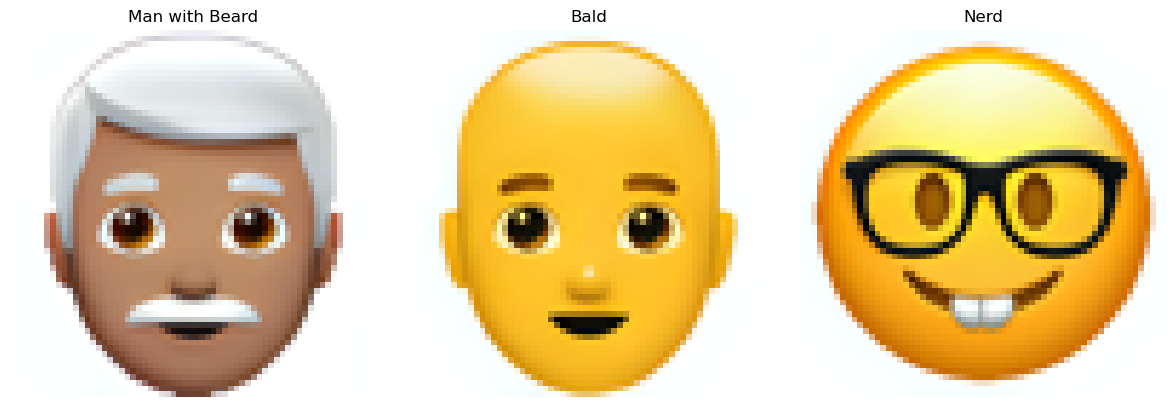

In [31]:
# get the first test image
test_images, _ = next(iter(test_dataloader2))
man_with_beard = test_images[0].unsqueeze(0)

test_images = test_images.numpy()

man_with_beard_test = test_images[0]

# Display the images
# Create a subplot with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the first test image
axes[0].imshow(np.squeeze(man_with_beard_test).transpose(1, 2, 0))
axes[0].set_title('Man with Beard')

# Plot the bald image
axes[1].imshow(bald)
axes[1].set_title('Bald')

# Plot the nerd image
axes[2].imshow(nerd)
axes[2].set_title('Nerd')

# Remove the axis labels
for ax in axes:
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


In [32]:
# transform the non tensor images to a tensor
transform = transforms.ToTensor()
nerd_tensor = transform(nerd).unsqueeze(0)
bald_tensor = transform(bald).unsqueeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


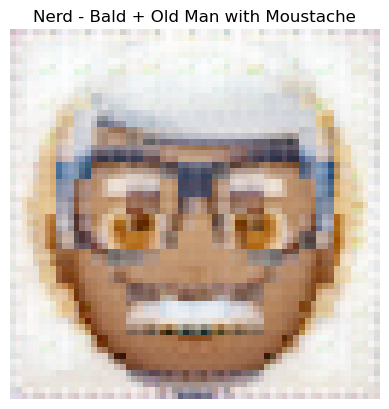

In [34]:
img_vecs = [nerd_tensor, bald_tensor, man_with_beard]

# Set the model to evaluation mode
model.eval()

# Encode the images
# Because we used skip connections, we must get each latent representation from each encoder
encoded_img_vecs = []
for img_vec in img_vecs:
    x1 = model.encoder1(img_vec)
    x2 = model.enconder2(x1)
    encoded_img_vec = model.encoder3(x2)
    encoded_img_vecs.append((x1, encoded_img_vec))


# We want to subtract the bald man from the nerd so we can add glasses to the man with beard
# For each list item subtract each item in the tuple from the corresponding item in the other tuple
# Then add the results
combined_encoding = []
for i in range(len(encoded_img_vecs[0])):
    x = torch.subtract(.5*encoded_img_vecs[0][i], .5*encoded_img_vecs[1][i])
    x = torch.add(1*x, encoded_img_vecs[2][i])
    combined_encoding.append(x)

out_x1 =  model.decoder1(combined_encoding[1])
out_x2 = torch.add(combined_encoding[0], model.decoder2(out_x1))
combined_image = model.decoder3(out_x2)

# Plot the combined image
plt.imshow(np.squeeze(combined_image.detach().numpy()).transpose(1, 2, 0))
plt.title('Nerd - Bald + Old Man with Moustache')
plt.axis('off')
plt.show()


## Problem 3 Discussion
While this is not a perfect representation, you can see that our vector math works! We can take the latent encodings of multiple images and perform vector operations to create a new image. In our case we subtracted a bald emoji from the nerd emoji to try and isolate the eye glasses to add it to an old man with a mustache. You can see that the glasses are clearly added with the old man's hair and mustache still represented. This image could be improved by using emoji's that are more closely related to each other. For example, the nerd and bald man emoji's are not very similar so there is noise introduced from their differences. Additionally, eyes present in the nerd and emoji are very different from the training set so that could be a reason for the noise as well. Finally, having skip connections in our model required us to create track of many latent encodings. 